### Predicting future wind speed with prior observations
- Using a linear regression, 
### Results
- For reference numerical model skill is MAE ~1.5-1.7 m/s
- Predicting 1-hour in advance, MAE ~ 0.9 m/s, Linear regression and Random Forest similar skill
- Predicting 6-hour in advance, MAE ~ 2.2 m/s, similar between models

In [1]:
# Needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime,timedelta
from scipy import io,signal
import time

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import BaseEstimator, TransformerMixin

ImportError: cannot import name 'BaseEstimator' from 'sklearn' (C:\ProgramData\Anaconda3\lib\site-packages\sklearn\__init__.py)

In [8]:
# Set paths to data
fobs = '../../offline_data/buoy_bulkwave_met_obs_qc.mat'
fpred = '../../offline_data/cfsr_buoy_met_pred.mat'

In [1]:
from sklearn import BaseEstimator, TransformerMixin

class CreateHistoryLabels(BaseEstimator, TransformerMixin):
    def __init__(self,hr_back=6):
        self.hr_back = hr_back
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        

# Collection of data-prepping functions
def matlab2datetime(matlab_datenum):
    day = datetime.fromordinal(int(matlab_datenum))
    dayfrac = timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return day + dayfrac

def load_data(fobs,fpred):
    # load matfiles
    obs = io.loadmat(fobs)
    pred = io.loadmat(fpred)
    
    # Estimate u,v for pred
    pred['u'] = pred['wndspd']*np.cos((90-pred['wnddir']+180)*np.pi/180.0)
    pred['v'] = pred['wndspd']*np.sin((90-pred['wnddir']+180)*np.pi/180.0)
    
    # Make datetime axes for each from datenum
    pred['t'] = [matlab2datetime(tt[0]) for tt in pred['time']] 
    obs['t'] = [matlab2datetime(tt[0]) for tt in obs['time']] 
    
    return (obs,pred)

def create_history_matrix(t,x,y,hr_back,hr_forward):

    # Generate prior wind speeds, up to X hours back in time using np.roll() like circshift in matlab
    trim = np.max([hr_back,hr_forward])

    # Time length
    Nt = len(t)

    # Make empty frames for history data
    X = np.zeros((Nt,hr_back))

    # Fill in with prior hours of data
    for ii in range(hr_back):    
        X[:,ii] = np.roll(x,ii)        

    # Create numerical weather prediction at forward hour
    p = np.roll(y,-hr_forward)

    # Create observed rolled forward for validation
    v = np.roll(x,-hr_forward)

    # Trim by setting nan
    X[:trim,:] = np.nan
    X[-trim:,:] = np.nan
    x[:trim] = np.nan
    x[-trim:] = np.nan
    p[:trim] = np.nan
    p[-trim:] = np.nan
    v[:trim] = np.nan
    v[-trim:] = np.nan
    t[:trim] = np.nan
    t[-trim:] = np.nan

    # Remove time-steps with NaN (including many observation times)
    msk1 = np.isnan(X)
    msk1 = msk1.any(axis=1)
    msk2 = np.isnan(y)
    msk3 = np.isnan(v)
    msk4 = np.isnan(p)
    msk = msk1 | msk2 | msk3 | msk4

    X = X[~msk,:]
    x = x[~msk]
    p = p[~msk]
    v = v[~msk]
    t = t[~msk]
    
    return (X, x, v, p, t, msk)

#----- Make yearly mean variable -----#
def make_yr_avg(time,x):    
    # Calc day of year
    doy = np.array([i.timetuple().tm_yday for i in time])-1

    # Calc avg for each day (include leap year)
    xa = np.zeros(366)
    for dd in range(366):
        msk = (doy == dd)
        xa[dd] = np.nanmean(x[msk])

    # Smooth this daily average wind vector
    # In future should wrap this before smoothing and then unwrap

    from scipy import signal
    xas = signal.savgol_filter(xa, 25*3, 2)

    plot_on = 0
    if plot_on == 1:
        fig, ax1 = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(uavg,label='Daily Avg')
        ax1.plot(uavgs,label='Smoothed')
        plt.ylabel('U [m/s]')
        ax1.legend()
        plt.xlabel('Day of Year')

    # Append avg to time series
    xa = xas[doy]
    
    return xa

def test_regression(HU,fu_o):
    # Train/test
    x_tr, x_te, y_tr, y_te = train_test_split(HU, fu_o, test_size = 0.25, random_state = 42)
    
    # Creating an object of LinearRegression class
    LR = LinearRegression()
    
    # fitting the training data
    LR.fit(x_tr,y_tr)
    
    # Make predictions
    y_p = np.squeeze(LR.predict(x_te))
    y = np.squeeze(y_te)

    # Evaluate error
    r2 = r2_score(y.T,y_p)
    mae = np.mean(np.abs(y.T-y_p))
    
    # Pass error back
    return (r2,mae)


IndentationError: expected an indented block (<ipython-input-1-18f117689512>, line 12)

In [10]:
# Load up data
(obs,pred) = load_data(fobs,fpred)

In [ ]:
# Test a linear regression for varying forecast hour and varying buoy loc
# This takes 231.96 seconds

# Select how many hours to go back in time
hr_back = 6

# Select with variable to predict
myvar = 'u' 

Nb = 21
Nf = 24
loc = np.arange(Nb)
hr_forward = np.arange(1,Nf+1)
r2 = np.zeros((Nb,Nf))
mae = np.zeros((Nb,Nf))
mae_nm = np.zeros((Nb,Nf))
bias_nm = np.zeros((Nb,Nf))
mae_br_nm = np.zeros((Nb,Nf))
buoy = []

# Loop over locations
start = time.time()
for b in range(Nb):
    
    for f in range(Nf):

        # Interp onto pred axis
        t1 = np.squeeze(pred['time'])
        x1 = np.squeeze(pred[myvar][:,b])
        t2 = np.squeeze(obs['time'])
        x2 = np.squeeze(obs[myvar][b,:])
        x2 = np.interp(t1,t2,x2)

        # Rename
        t = t1
        x = x1
        y = x2

        # Generate history matrix and trimmed/cleaned vectors
        (X, x, v, p, t, msk) = create_history_matrix(t,x,y,hr_back,hr_forward[f])
        v = np.expand_dims(v,axis=1)
        p = np.expand_dims(p,axis=1)

        # Create yearly average
        tax = pred['t']
        tax = [tax[i] for i in range(len(tax)) if ~msk[i]]
        xa = make_yr_avg(tax,x)
        xa = np.expand_dims(xa,1) # Make 2D for concat

        # Concatenate xa to X
        X = np.concatenate((X,xa),axis=1)

        # Concatenate p to X
        X = np.concatenate((p,X),axis=1)
        
        # Linear regression
        (r2[b,f],mae[b,f]) = test_regression(X,v)
        
        # Numerical Model prediction error 
        mae_nm[b,f] = np.mean(np.abs(p-v))
        bias_nm[b,f] = np.mean(p-v)
        mae_br_nm[b,f] = np.mean(np.abs(p-v-bias_nm[b,f]))
        

end = time.time()
print('Finished in {:4.2f} seconds'.format(end - start))


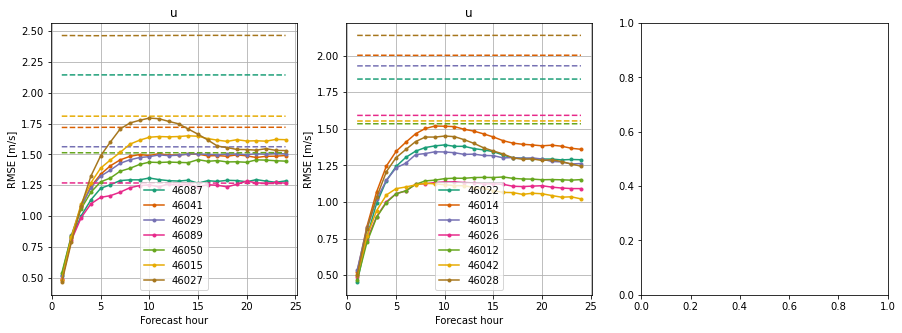

In [69]:
cmap = cm.get_cmap('Dark2')

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

for b in range(7):
    ax1.plot(hr_forward,mae[b,:],'.-',label=obs['id'][b][0][0],color=cmap((1/7)*b))
    ax1.plot(hr_forward,mae_nm[b,:],'--',color=cmap((1/7)*b))
ax1.set_xlabel('Forecast hour')
ax1.set_ylabel('RMSE [m/s]')
ax1.set_title('u')
ax1.grid()
ax1.legend()

for b in range(7):
    ax2.plot(hr_forward,mae[7+b,:],'.-',label=obs['id'][7+b][0][0],color=cmap((1/7)*b))
    ax2.plot(hr_forward,mae_nm[7+b,:],'--',color=cmap((1/7)*b))
ax2.set_xlabel('Forecast hour')
ax2.set_ylabel('RMSE [m/s]')
ax2.set_title('u')
ax2.grid()
ax2.legend()

for b in range(7):
    ax2.plot(hr_forward,mae[14+b,:],'.-',label=obs['id'][14+b][0][0],color=cmap((1/7)*b))
    ax2.plot(hr_forward,mae_nm[14+b,:],'--',color=cmap((1/7)*b))
ax2.set_xlabel('Forecast hour')
ax2.set_ylabel('RMSE [m/s]')
ax2.set_title('u')
ax2.grid()
ax2.legend()

In [40]:
cmap(1.1)

(0.4, 0.4, 0.4, 1.0)

In [ ]:
# How many time steps in each buoy record?
N = obs['u'].shape[0]
my_count = np.arange(N)
for i in range(N):
    my_count[i] = np.sum(~np.isnan(obs['u'][i,:]),color=
print(my_count)

In [ ]:
plt.plot(mae.T)
plt.ylabel('Mean Absolute Error of U [m/s]')
plt.xlabel('Forecast Hour')

In [ ]:
# Linear Regression, varying history length

loc = 1
hr_forward = 3

for hr_back in np.arange(1,4):
    # Prep data
    (tn,HU,HV,fu_o,fv_o,fu_p,fv_p,ou,ov,pu,pv) = prep_data(obs,pred,loc,hr_back,hr_forward)
    
    # Train/test
    x_tr, x_te, y_tr, y_te = train_test_split(HU, fu_o, test_size = 0.25, random_state = 42)
    
    # Creating an object of LinearRegression class
    LR = LinearRegression()
    
    # fitting the training data
    LR.fit(x_tr,y_tr)
    
    # Make predictions
    y_p = np.squeeze(LR.predict(x_te))
    y = np.squeeze(y_te)

    # Evaluate error
    r2 = r2_score(y.T,y_p)
    mae = np.mean(np.abs(y.T-y_p))
    print([hr_back,r2,mae])


In [ ]:
mae = np.mean(np.abs(pu-ou))
print(mae)

In [ ]:
# Linear regression for residual



In [ ]:
# Generate prior wind speeds, up to X hours back in time using np.roll() like circshift
hr_back = 6
hr_forward = 1
trim = np.max([hr_back,hr_forward])

HU = pd.DataFrame()
HV = pd.DataFrame()
tn = np.array(t.copy())

for ii in range(hr_back):
    col = str(ii)
    HU[col] = np.roll(ou,ii)
    HV[col] = np.roll(ov,ii)

# Create future time step to predict
fu = np.roll(ou,-hr_forward)
fv = np.roll(ov,-hr_forward)

# Create prediction vector for use later
fu_p = np.roll(pu,-hr_forward)
fv_p = np.roll(pv,-hr_forward)
    
# Trim ends
HU = HU[trim:-trim]
HV = HV[trim:-trim]
fu = fu[trim:-trim]
fv = fv[trim:-trim]
tn = tn[trim:-trim]
ov = ov[trim:-trim]
ou = ou[trim:-trim]
fu_p = fu_p[trim:-trim]
fv_p = fv_p[trim:-trim]

# Nan out times with any NaNs
msk1 = HU.isnull()
msk1 = msk1.any(axis=1)
msk2 = np.isnan(fu)
msk = msk1 | msk2
HU[msk] = np.nan
HV[msk] = np.nan
fu[msk] = np.nan
fv[msk] = np.nan

# Remove NaN values
fu = fu[~np.isnan(fu)]
fv = fv[~np.isnan(fv)]
HU = HU.dropna()
HV = HV.dropna()
tn = tn[~msk]
ou = ou[~msk]
ov = ov[~msk]
fu_p = fu_p[~msk]
fv_p = fv_p[~msk]

# Make yearly mean variable
# day of year
doy = np.array([ti.timetuple().tm_yday for ti in tn])-1
uavg = np.zeros(366)
vavg = np.zeros(366)
for dd in range(366):
    msk = (doy == dd)
    uavg[dd] = np.nanmean(ou[msk])
    vavg[dd] = np.nanmean(ov[msk])
    
# Smooth this daily average wind vector
# In future should wrap this before smoothing!

from scipy import signal
uavgs = signal.savgol_filter(uavg, 25*3, 2)
vavgs = signal.savgol_filter(vavg, 25*3, 2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(uavg,label='Daily Avg')
ax1.plot(uavgs,label='Smoothed')
plt.ylabel('U [m/s]')
ax1.legend()
plt.xlabel('Day of Year')

ax2.plot(vavg,label='Daily Avg')
ax2.plot(vavgs,label='Smoothed')
plt.ylabel('V [m/s]')
ax2.legend()
plt.xlabel('Day of Year')

# Append avg to time series
uavg_t = uavgs[doy]
uavg_t = np.expand_dims(uavg_t,1)
vavg_t = vavgs[doy]
vavg_t = np.expand_dims(vavg_t,1)
HU = np.concatenate((HU,uavg_t),axis=1)
HV = np.concatenate((HU,uavg_t),axis=1)

In [ ]:
# train test sets
x_tr, x_te, y_tr, y_te = train_test_split(HU, fu, test_size = 0.25, random_state = 42)

In [ ]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_tr,y_tr)
# Make predictions
y_p = np.squeeze(LR.predict(x_te))
y = np.squeeze(y_te)

r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y.T-y_p))
print([r2,mae])
print(LR.coef_)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import time

start = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state= 40)
rf.fit(x_tr,y_tr)
end = time.time()
print('Finished in {:4.2f} seconds'.format(end - start))


In [ ]:
y_p = rf.predict(x_te)
r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y_p-y_te))
print([r2,mae])

### Try adding prediction forecast to regression



In [ ]:
HUa = np.concatenate((HU,np.expand_dims(fu_p,1)),axis=1)
x_tr, x_te, y_tr, y_te = train_test_split(HUa, fu, test_size = 0.25, random_state = 42)
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_tr,y_tr)
# Make predictions
y_p = np.squeeze(LR.predict(x_te))
y = np.squeeze(y_te)

r2 = r2_score(y.T,y_p)
mae = np.mean(np.abs(y.T-y_p))
print([r2,mae])
print(LR.coef_)

Basically the same skill as with the prediction alone.